In [1]:
import numpy as np
import salem
import xarray as xr

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
usgs_file = salem.open_wrf_dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/usgs_1h/wrfout_test')
wur_file = salem.open_wrf_dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur_1h/wrfout_test')
wur_lcz_file = salem.open_wrf_dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur_lcz_1h/wrfout_test')
modis_file = salem.open_wrf_dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/modis_lcz_1h/wrfout_test')

usgs_file

<xarray.Dataset> Size: 10GB
Dimensions:                (south_north: 165, west_east: 220, time: 45,
                            bottom_top: 60, soil_layers: 3, seed_dim: 7)
Coordinates:
    lat                    (south_north, west_east) float32 145kB 52.29 ... 5...
    lon                    (south_north, west_east) float32 145kB 4.728 ... 5...
    xtime                  (time) datetime64[ns] 360B ...
  * time                   (time) datetime64[ns] 360B 2019-07-23T06:00:00 ......
  * west_east              (west_east) float64 2kB -8.411e+04 ... -6.221e+04
  * south_north            (south_north) float64 1kB 3.535e+04 ... 5.175e+04
Dimensions without coordinates: bottom_top, soil_layers, seed_dim
Data variables: (12/211)
    LU_INDEX               (time, south_north, west_east) float32 7MB ...
    ZNU                    (time, bottom_top) float32 11kB ...
    ZNW                    (time, bottom_top) float32 11kB ...
    ZS                     (time, soil_layers) float32 540B ...
    DZS                    (time, soil_layers) float32 540B ...
    VAR_SSO                (time, south_north, west_east) float32 7MB ...
    ...                     ...
    PRESSURE               (time, bottom_top, south_north, west_east) float32 392MB ...
    GEOPOTENTIAL           (time, bottom_top, south_north, west_east) float32 392MB ...
    Z                      (time, bottom_top, south_north, west_east) float32 392MB ...
    SLP                    (time, south_north, west_east) float32 7MB ...
    PRCP_NC                (time, south_north, west_east) float32 7MB ...
    PRCP_C                 (time, south_north, west_east) float32 7MB ...
Attributes: (12/137)
    TITLE:                            OUTPUT FROM WRF V4.6.0 MODEL
    START_DATE:                      2019-07-23_06:00:00
    SIMULATION_START_DATE:           2019-07-23_06:00:00
    WEST-EAST_GRID_DIMENSION:        221
    SOUTH-NORTH_GRID_DIMENSION:      166
    BOTTOM-TOP_GRID_DIMENSION:       61
    ...                              ...
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    pyproj_srs:                      +proj=lcc +lat_0=51.9647178649902 +lon_0...

In [3]:
usgs_luindex = usgs_file.LU_INDEX.isel(time=5)
wur_luindex = wur_file.LU_INDEX.isel(time=5)
wur_lcz_luindex = wur_lcz_file.LU_INDEX.isel(time=5)
modis_luindex = modis_file.LU_INDEX.isel(time=5)

In [4]:
c_modis = [
    [0.43, 0.89, 1.0],
    [0.67, 0.94, 1.0],
    [1.0, 0.77, 0.89],
    [1.0, 0.6, 0.8],
    [1.0, 0.0, 1.0],
    [0.50, 0.0, 0.50],
    [0.0, 0.0, 0.50],
    [0.27, 0.27, 1.0],
    [0.2, 0.4, 1.0],
    [0.52, 0.64, 1.0],
    [1.0, 1.0, 1.0],  # URBAN IN ORIGINAL FILE
    [0.8, 0.8, 0.8],
    [0.70, 0.70, 0.70],
    [0.0, 0.0, 0.0],
    [0.6, 0.6, 0.6],
    [0.35, 0.35, 0.35],
    [0.50, 0.50, 0.0],
    [0.0, 0.36, 0.0],
    [0.0, 0.50, 0.0],
    [0.2, 0.6, 0.4],
    [0.62, 0.84, 0.0],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.83, 1.0, 0.35],
    [1.0, 1.0, 0.0],
    [1.0, 0.72, 0.44],
    [1.0, 0.6, 0.0],
    [1.0, 0.4, 0.0],
    [1.0, 0.0, 0.0],
    [0.64, 0.44, 1.0],
    [0.74, 0.29, 0.0],
    [0.67, 0.0, 0.22],
    [0.52, 0.0, 0.0],
]

c_usgs = np.array([
    [1,0,0],          #  1 Urban and Built-up Land
    [1,1,0],          #! 2 Dryland Cropland and Pasture
    [1,1,.2],         #  3 Irrigated Cropland and Pasture
    [1,1,.3],         #  4 Mixed Dryland/Irrigated Cropland and Pasture
    [.7,.9,.3],       #  5 Cropland/Grassland Mosaic
    [.7,.9,.3],       #  6 Cropland/Woodland Mosaic
    [0,1,0],          #  7 Grassland
    [.3,.7,0],        #  8 Shrubland
    [.82,.41,.12],    #  9 Mixed Shrubland/Grassland
    [1,.84,.0],       #  10 Savanna
    [.2,.8,.4],       #  11 Deciduous Broadleaf Forest
    [.2,.8,.2],       #  12 Deciduous Needleleaf Forest
    [0,.4,.2],        #  13 Evergreen Broadleaf Forest
    [0,.4,0],         #! 14 Evergreen Needleleaf Forest 
    [.2,.6,.2],       #  15 Mixed Forests
    [0,0,.88],        #  16 Water Bodies
    [0,1,1],          #! 17 Herbaceous Wetlands
    [.2,1,1],         #  18 Wooden Wetlands
    [.914,.914,.7],   #  19 Barren or Sparsely Vegetated
    [.86,.08,.23],    #  20 Herbaceous Tundraa
    [.86,.08,.23],    #  21 Wooded Tundra
    [.97,.5,.31],     #! 22 Mixed Tundra
    [.91,.59,.48],   #! 23 Barren Tundra
    [1,1,1]          #! 24 Snow and Ice
    ])



cmap = LinearSegmentedColormap.from_list('luse', c_usgs, N=24)
levels = np.arange(0, 24)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

cmap2 = LinearSegmentedColormap.from_list('luse', c_modis, N=61)
levels2 = np.arange(0, 61)
norm2 = BoundaryNorm(levels2, ncolors=cmap2.N, clip=True)

In [5]:
ax_options = {
    'color': 'black',
    'linestyle': 'dotted',
    'linewidth': 0.5,
    'zorder': 103,
    'draw_labels': True,
    'x_inline': False,
    'y_inline': False,
}
title_options = {
    'loc': 'left',
    'fontsize': 'x-large',
    'fontweight': 'bold',
}
proj = ccrs.PlateCarree()
extent = [usgs_luindex.lon.min(), usgs_luindex.lon.max(), usgs_luindex.lat.min(), usgs_luindex.lat.max()]

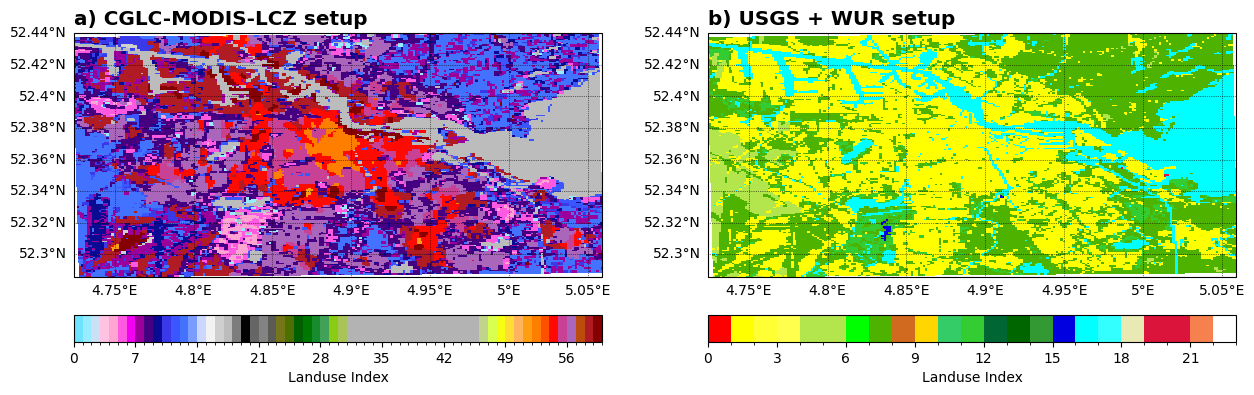

In [6]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1, projection=proj)
gl1 = ax1.gridlines(**ax_options)
gl1.right_labels = False
gl1.top_labels = False
ax1.set_extent(extent)
ct1 = ax1.pcolormesh(
    modis_luindex.lon, modis_luindex.lat, modis_luindex, cmap=cmap2, norm=norm2, transform=ccrs.PlateCarree()
)
ax1.coastlines(linewidth=1.0, resolution='10m')
ax1.set_title('a) CGLC-MODIS-LCZ setup', **title_options)
cbar = fig.colorbar(ct1, orientation='horizontal', fraction=0.09, pad=0.1, label='Landuse Index', ax=ax1)
#cbar1.ax.set_yticklabels(labels)

ax2 = fig.add_subplot(1, 2, 2, projection=proj)
gl2 = ax2.gridlines(**ax_options)
gl2.right_labels = False
gl2.top_labels = False
ax2.set_extent(extent)
ct2 = ax2.pcolormesh(
    wur_luindex.lon, wur_luindex.lat, wur_luindex, cmap=cmap, norm=norm, transform=ccrs.PlateCarree()
)
ax1.coastlines(linewidth=1.0, resolution='10m')
ax2.set_title('b) USGS + WUR setup', **title_options)
cbar = fig.colorbar(ct2, orientation='horizontal', fraction=0.09, pad=0.1, label='Landuse Index', ax=ax2)